<a href="https://colab.research.google.com/github/tjstone1/house-pricing-analysis/blob/main/housing_price_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
df <- read.csv("sample_data/properties.csv")
install.packages("lmtest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



First we check the structure of the data by using the head function. It's immediately clear that the data must be cleaned.

In [33]:
head(df)

,price,areaCode,propertyType,areaValue,areaUnit,bedrooms,bathrooms,receptions,epcRating,tenure,councilTaxBand
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1075000,OX1,House,2155.0,sq ft,3,2,2,,Freehold,TBC
2,650000,OX25,New development,NA,,NaN,NaN,NaN,,Freehold,TBC
3,2750000,OX28,House,8248.0,sq ft,10,5,4,E,Freehold,H
4,950000,OX2,Flat / Apartment,1632.0,sq ft,3,2,2,C,Leasehold. Lease Expiry: 04/05/2128 (102 years remaining),F
5,615000,OX1,Flat / Apartment,826.0,sq ft,2,2,1,B,Leasehold. Lease Expiry: 01/09/2142 (117 years remaining),E
6,1750000,RG9,House,1.6,Ac,5,3,3,E,Freehold,F


We remove all incomplete records

In [34]:
listings <- na.omit(df)
listings <- listings[!apply(listings == "", 1, any), ]

We'll clean the data further:


1.   Standardise area measurements so that they are all in square feet.
2.   Clean tenure column so that "Leasehold" and "Share of Freehold" so that their formatting is consistent.
3.   Convert tenure column to boolean as only a small minority of properties are not Freehold. This also enables us to turn the data into numbers which can be used in our model (1 or 0).
4.   Encode epc rating and tax band so that they have numeric values. As they are naturally ordered, one-hot encoding is not necessary.




In [35]:
library(dplyr)
# 1
listings <- listings %>% mutate(
  areaValue = if_else(areaUnit == "Ac", areaValue * 43560, areaValue),
  areaUnit = "sq ft"
)

# 2
listings$tenure_clean <- ifelse(grepl("Share of Freehold", listings$tenure, ignore.case = TRUE),
                                "Share of Freehold",
                         ifelse(grepl("Leasehold", listings$tenure, ignore.case = TRUE),
                                "Leasehold",
                                "Freehold"))

listings$tenure_clean <- factor(listings$tenure_clean,
                                levels = c("Freehold", "Leasehold", "Share of Freehold"))
                                one_hot <- model.matrix(~ tenure_clean - 1, data = listings)

# 3
listings$isFreehold <- as.integer(listings$tenure_clean == "Freehold")

# 4
listings$epc_numeric <- as.numeric(factor(listings$epcRating,
                                         levels = c("G", "F", "E", "D", "C", "B", "A")))
listings <- listings[listings$councilTaxBand != "TBC", ]
listings$tax_numeric <- as.numeric(factor(listings$councilTaxBand,
                                         levels = c("A", "B", "C", "D", "E", "F", "G", "H")))

head(listings)

,price,areaCode,propertyType,areaValue,areaUnit,bedrooms,bathrooms,receptions,epcRating,tenure,councilTaxBand,tenure_clean,isFreehold,epc_numeric,tax_numeric
,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<int>,<dbl>,<dbl>
3,2750000,OX28,House,8248,sq ft,10,5,4,E,Freehold,H,Freehold,1,3,8
4,950000,OX2,Flat / Apartment,1632,sq ft,3,2,2,C,Leasehold. Lease Expiry: 04/05/2128 (102 years remaining),F,Leasehold,0,5,6
5,615000,OX1,Flat / Apartment,826,sq ft,2,2,1,B,Leasehold. Lease Expiry: 01/09/2142 (117 years remaining),E,Leasehold,0,6,5
6,1750000,RG9,House,69696,sq ft,5,3,3,E,Freehold,F,Freehold,1,3,6
7,899995,OX7,House,2246,sq ft,4,3,2,D,Freehold,G,Freehold,1,4,7
8,595000,OX2,House,1323,sq ft,4,5,2,C,Freehold,E,Freehold,1,5,5


The number of houses is large compared to other property types, this means one-hot encoding is not appropriate for this data. Instead we'll turn property type into a boolean to check whether it's a house or not.

In [36]:
table(listings$propertyType)


        Bungalow Flat / Apartment            House  New development 
               1               10              177                3 

In [37]:
table(listings$propertyType)
listings$isHouse <- ifelse(listings$propertyType == "House", 1, 0)


        Bungalow Flat / Apartment            House  New development 
               1               10              177                3 

We use stepwise regression to identify the best-fitting model by starting with a full model (all predictors and selected interactions) and a null model (1). The response variable is log(price) to stabilise variance and improve model fit. The model with the lowest AIC is chosen as the optimal balance between complexity and goodness of fit.

In [38]:
full_model <- lm(log(price) ~
                 bathrooms * bedrooms * areaValue * receptions *
                 isHouse + isFreehold + tax_numeric + epc_numeric,
               data = listings)
null_model <- lm(log(price) ~ 1, data = listings)

step_model <- step(null_model, scope = list(lower = null_model, upper = full_model), direction = "both")

summary(step_model)

Start:  AIC=-151.49
log(price) ~ 1

              Df Sum of Sq    RSS     AIC
+ bedrooms     1    37.893 47.618 -261.31
+ bathrooms    1    35.175 50.336 -250.71
+ receptions   1    35.057 50.454 -250.26
+ tax_numeric  1    31.894 53.617 -238.65
+ areaValue    1    10.171 75.340 -173.68
+ isFreehold   1     5.001 80.510 -161.00
+ epc_numeric  1     3.576 81.936 -157.65
+ isHouse      1     2.847 82.665 -155.96
<none>                     85.511 -151.49

Step:  AIC=-261.31
log(price) ~ bedrooms

              Df Sum of Sq    RSS     AIC
+ tax_numeric  1     7.670 39.948 -292.86
+ bathrooms    1     5.992 41.626 -285.00
+ receptions   1     5.558 42.060 -283.01
+ areaValue    1     4.844 42.774 -279.80
<none>                     47.618 -261.31
+ epc_numeric  1     0.203 47.415 -260.13
+ isHouse      1     0.052 47.567 -259.52
+ isFreehold   1     0.001 47.617 -259.31
- bedrooms     1    37.893 85.511 -151.49

Step:  AIC=-292.86
log(price) ~ bedrooms + tax_numeric

              Df Sum of 


Call:
lm(formula = log(price) ~ bedrooms + tax_numeric + areaValue + 
    bathrooms + receptions + isHouse + bathrooms:receptions + 
    bedrooms:receptions + areaValue:isHouse + bedrooms:bathrooms + 
    bedrooms:bathrooms:receptions, data = listings)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8189 -0.2763 -0.0054  0.2299  0.8947 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    1.331e+01  3.570e-01  37.280  < 2e-16 ***
bedrooms                      -7.714e-02  1.074e-01  -0.718 0.473675    
tax_numeric                    1.481e-01  2.987e-02   4.957 1.65e-06 ***
areaValue                      2.504e-06  7.873e-07   3.180 0.001735 ** 
bathrooms                     -5.760e-01  1.377e-01  -4.185 4.47e-05 ***
receptions                    -1.825e-01  1.483e-01  -1.230 0.220170    
isHouse                        2.308e-02  1.299e-01   0.178 0.859128    
bathrooms:receptions           1.864e-01  4.002e-02  

Finally we perform a Breusch-Pagan test to test for homoscedasticity. In this instance p > 0.05 so we can accept the null hypothesis of constant variance of residuals. This means our model is likely to be trustworthy.


	studentized Breusch-Pagan test

data:  model
BP = 16.193, df = 11, p-value = 0.1341


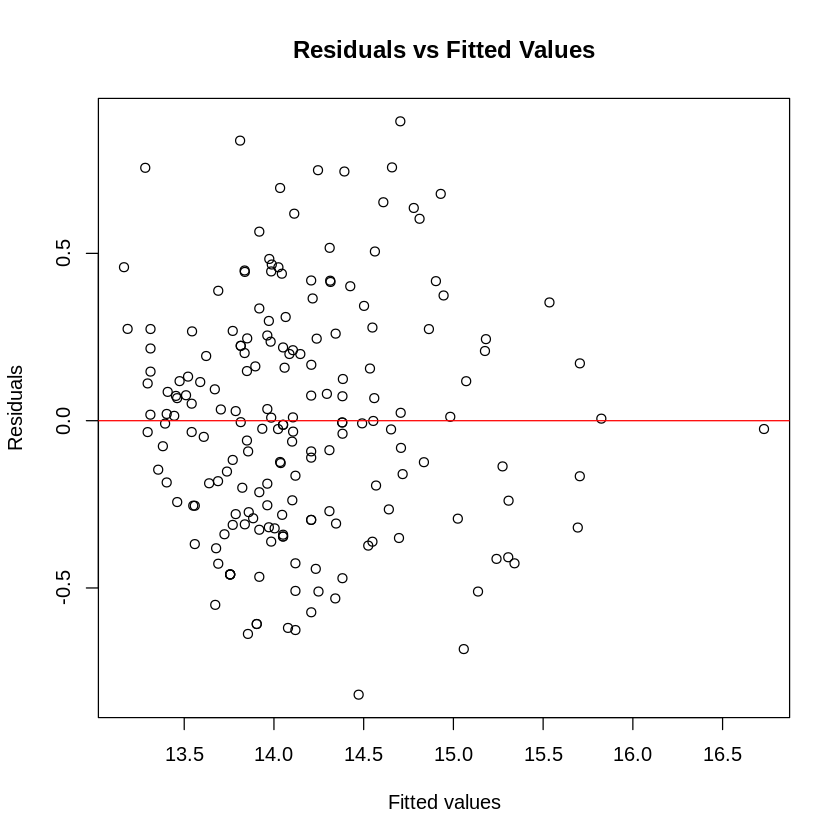

In [39]:
library(lmtest)
model <- lm(log(price) ~ bedrooms + tax_numeric + areaValue +
    bathrooms + receptions + isHouse + bathrooms:receptions +
    bedrooms:receptions + areaValue:isHouse + bedrooms:bathrooms +
    bedrooms:bathrooms:receptions, data = listings)
plot(model$fitted.values, residuals(model),
     xlab = "Fitted values",
     ylab = "Residuals",
     main = "Residuals vs Fitted Values")
abline(h = 0, col = "red")

bptest(model)


## Final Stepwise Regression Model Summary (AIC = -381.14)

### Model Formula

```r
log(price) ~ bedrooms + tax_numeric + areaValue +
    bathrooms + receptions + isHouse + bathrooms:receptions +
    bedrooms:receptions + areaValue:isHouse + bedrooms:bathrooms +
    bedrooms:bathrooms:receptions
```
# Model Summary and Interpretation

The selected model explains approximately **71.6% of the variation** in the logarithm of property prices (adjusted R² = 0.7158), indicating a strong fit.

## Key takeaways

- **Number of bedrooms (`bedrooms`)** does not have a significant main effect but plays a key role through interactions.
- **Council tax band (`tax_numeric`)** is a highly significant positive predictor, reflecting the importance of location and property valuation tiers.
- **Property size (`areaValue`)** is a significant positive predictor of log-price, with its effect modified by whether the property is a house (`isHouse`).
- **Bathroom count** has a significant negative main effect but a positive interaction with **receptions**, showing that additional bathrooms increase price more when there are more reception rooms.
- **Reception rooms (`receptions`)** have a non-significant main effect but appear in multiple interaction terms.
- The **interaction between bathrooms and receptions** is strongly significant.
- Other important interactions include:
  - `areaValue:isHouse`: the effect of size differs between houses and other property types.
  - `bedrooms:bathrooms`: bedrooms and bathrooms together influence price.
  - `bedrooms:bathrooms:receptions`: a three-way interaction revealing a complex relationship among these features.

## Model diagnostics

- **Residual standard error** on log(price) is approximately **0.358**, indicating reasonable model fit.
- **Multiple R-squared:** 0.7322, **Adjusted R-squared:** 0.7158 meaning strong explanatory power.
- The model's **AIC of -381.14** was the lowest of all candidates suggesting the best fit to the underlying data.

## Interpretation

This model highlights that property price is influenced by a complex interplay of features rather than isolated effects. While bedrooms alone do not significantly predict price, their interaction with bathrooms and receptions is crucial, suggesting the value of bedrooms depends on the overall property layout. The significant interaction between property size and house status indicates that the price impact of size varies between houses and other property types. The strong effect of council tax band underscores the importance of location and local valuation criteria. The negative main effect of bathrooms combined with a positive interaction with receptions suggests additional bathrooms add value primarily in properties with more reception rooms.

## Recommendations

- Explore further **non-linear transformations** or **alternative regression methods** (e.g., generalized linear models or weighted least squares) to handle possible heteroscedasticity.
- Consider adding **postcode-level variables** (`areaCode`) to capture spatial effects.
- Investigate more **interaction terms** and possibly **higher-order polynomials** to capture complex relationships.
- Perform **model validation** using out-of-sample data to ensure generalisability.
- Use the model insights to inform property valuation, focusing on how the combination of bedrooms, bathrooms, receptions, and property type affects price rather than treating features independently.

